In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Number of cross validation folds, and scoring criteria
n_folds = 10
scoring = {'Log_Loss': make_scorer(log_loss, greater_is_better=False), 
           'Brier_Loss': make_scorer(brier_score_loss, greater_is_better=False), 
           'Accuracy': make_scorer(accuracy_score)}

In [3]:
df = pd.read_csv('mm_data.csv')
Y = df['result_class']
X = df.drop(columns=['result_class','result_regr'])
X.shape

(1334, 35)

<AxesSubplot:>

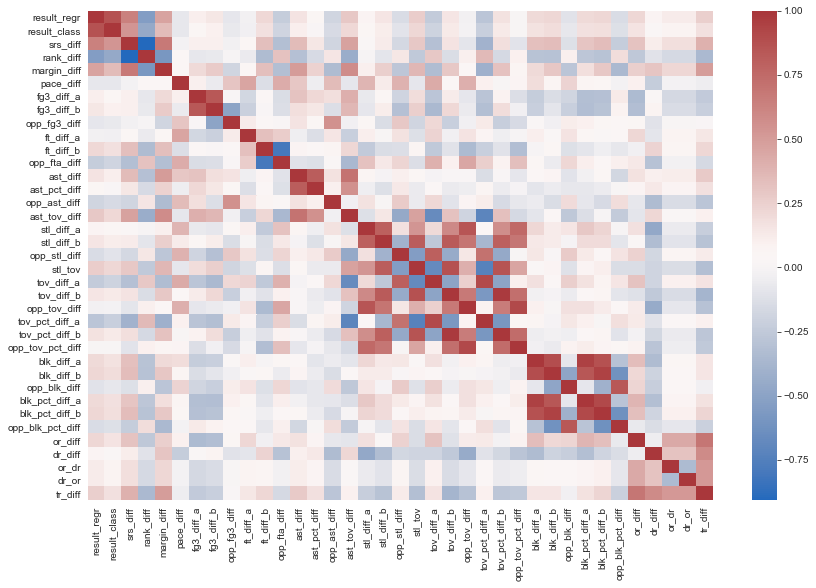

In [4]:
corr = df.corr('spearman')
fig = plt.figure(figsize=(14,9))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='vlag')

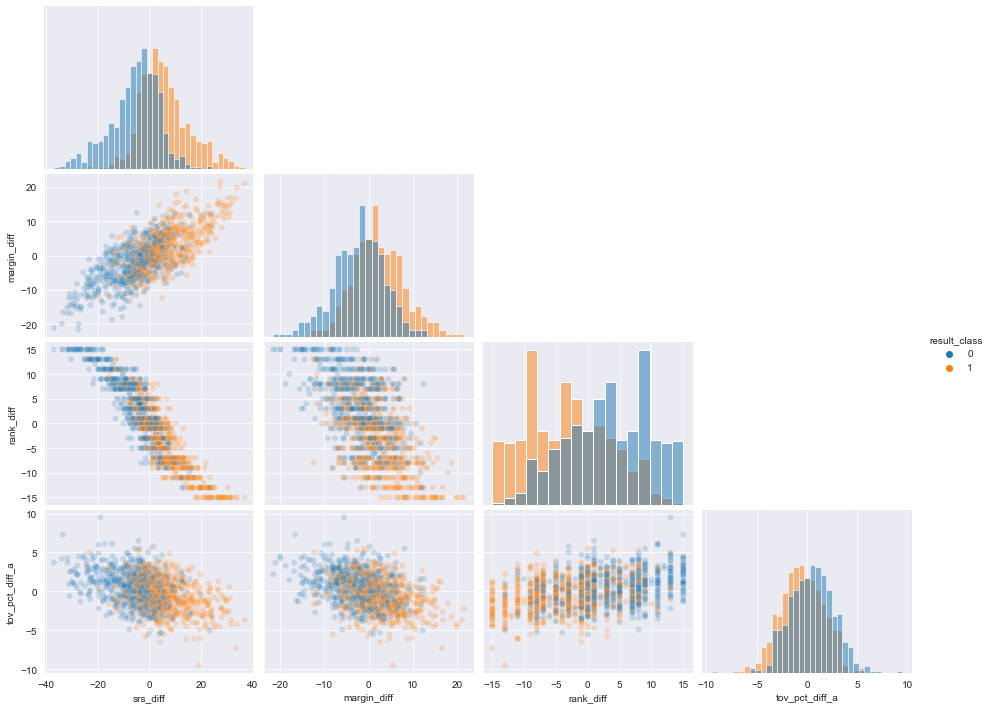

In [5]:
# _ = plt.scatter(df['srs_diff'], df['result_regr'], marker='+', alpha=0.4)
# _ = sns.scatterplot('srs_diff', 'result_regr', data=df, alpha=0.4)
sns.pairplot(df[['result_class','srs_diff','margin_diff','rank_diff','tov_pct_diff_a']], 
             hue='result_class', corner=True, diag_kind='hist', aspect=1.3,
             kind='scatter', plot_kws={'alpha':0.2})

### Principal Component Analysis

In [6]:
pca = PCA(n_components=0.95, svd_solver='full', whiten=True)
pca.fit(X)
var_explained = pd.Series(pca.explained_variance_ratio_)
cum_var_explained = var_explained.cumsum()
scree = pd.DataFrame({'var_explained':var_explained, 'cum_var_explained':cum_var_explained})

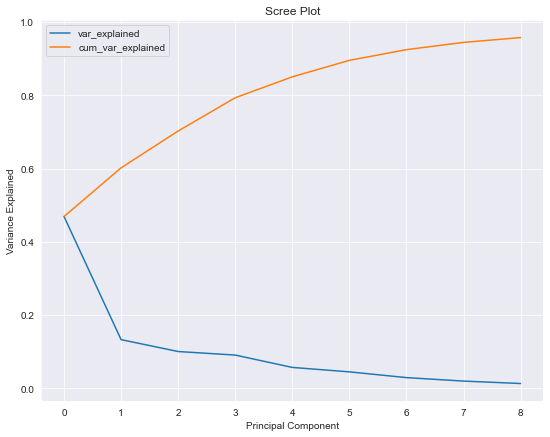

In [7]:
_ = scree.plot(kind='line', figsize=(9,7), title='Scree Plot', xlabel='Principal Component', ylabel='Variance Explained')

In [8]:
pc_data = pd.DataFrame(PCA(n_components=1, svd_solver='full', whiten=True).fit_transform(X))
pc_data.columns = ['PC1']
pc_data['Class'] = Y

<AxesSubplot:xlabel='PC1', ylabel='Count'>

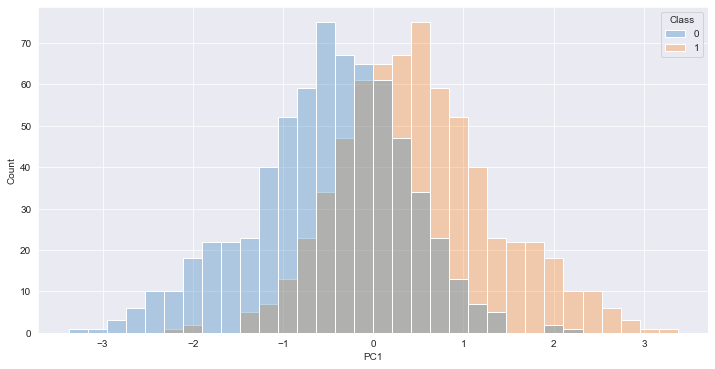

In [9]:
fig = plt.figure(figsize=(12,6))
sns.histplot(data=pc_data, x='PC1', hue='Class', alpha=0.3)

### Dummy Classifier
#### Better-ranked team predicted as victor; ties settled by margin_diff

In [10]:
dummy_preds = X['rank_diff'].apply(lambda x: 1 if x<0 else (0 if x>0 else -1))
backup = X['margin_diff'].apply(lambda x: 1 if x>0 else 0)
dummy_preds[dummy_preds < 0] = backup[dummy_preds < 0]

In [11]:
row_cuts = (pd.Series([0, 1, 2, 3, 4, 5, 6, 6, 6, 6, 6])*133 + pd.Series([0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4])*134).tolist()
dummy_acc = []
for i in range(10):
    rows = list(range(row_cuts[i], row_cuts[i+1]))
    dummy_acc.append(accuracy_score(Y[rows], dummy_preds[rows]))
print('Dummy Classifier:  Accuracy Metric =', 100*np.round(np.mean(dummy_acc) - 0.5*np.std(dummy_acc), 4))

Dummy Classifier:  Accuracy Metric = 66.86


### Gradient Boosted Tree

In [12]:
gbc = GradientBoostingClassifier(random_state=321)
parameters = {
    "learning_rate" : [0.1, 0.2, 0.4, 0.6, 0.8, 1],  # Shrinkage parameter to prevent over-fitting
    "max_depth" : [1],  # Maximum depth of individual trees
    "n_estimators" : [6, 8, 10, 12, 14, 16, 18],  # Number of boosting stages
    }
clf = GridSearchCV(gbc, param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_)
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['BrierLoss_metric'] = -np.round(1/(cv_out['mean_test_Brier_Loss'] - 0.5*cv_out['std_test_Brier_Loss']), 2)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
# cv_out['LogLoss_metric'] = -100*np.round(1/cv_out['mean_test_Log_Loss'], 4)
# cv_out['BrierLoss_metric'] = -np.round(1/cv_out['mean_test_Brier_Loss'], 2)
# cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_learning_rate', 'param_max_depth', 'param_n_estimators', 
                     'LogLoss_metric', 'BrierLoss_metric', 'Accuracy_metric']]

,param_learning_rate,param_max_depth,param_n_estimators,LogLoss_metric,BrierLoss_metric,Accuracy_metric
24,0.6,1,12,10.40,3.59,72.15
23,0.6,1,10,10.36,3.58,72.04
18,0.4,1,14,10.26,3.54,71.78
25,0.6,1,14,10.25,3.54,71.75
21,0.6,1,6,10.21,3.53,71.65
31,0.8,1,12,10.20,3.52,71.63


In [13]:
gbc = GradientBoostingClassifier(learning_rate=0.6, max_depth=1, n_estimators=12, random_state=321)
gbc.fit(X, Y)
feature_importances = pd.DataFrame({'feature':X.columns, 
                                    'importance':gbc.feature_importances_}).sort_values(by='importance', ascending=False)
feature_importances.loc[feature_importances['importance']>0]

,feature,importance
0,srs_diff,0.883363
9,opp_fta_diff,0.044294
22,tov_pct_diff_b,0.031847
11,ast_pct_diff,0.029166
5,fg3_diff_b,0.011330


### Random Forest

In [14]:
rfc = RandomForestClassifier(n_estimators=400, random_state=321)
parameters = {
    "max_features" : [9, 12, 15, 18],  # Number of features considered at each split (default = sqrt(p))
    "min_samples_leaf" : [8, 12, 16, 20, 24, 28, 32],  # Minimum number of samples per leaf (default = 1)
    }
clf = GridSearchCV(rfc, param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_)
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_max_features', 'param_min_samples_leaf', 
                     'LogLoss_metric', 'Accuracy_metric']]

,param_max_features,param_min_samples_leaf,LogLoss_metric,Accuracy_metric
15,15,12,9.74,70.26
24,18,20,9.68,70.09
25,18,24,9.63,69.95
23,18,16,9.61,69.89
19,15,28,9.60,69.84
14,15,8,9.58,69.78


In [15]:
rfc = RandomForestClassifier(max_features=15, min_samples_leaf=12, n_estimators=400, random_state=321)
rfc.fit(X, Y)
feature_importances = pd.DataFrame({'feature':X.columns, 
                                    'importance':rfc.feature_importances_}).sort_values(by='importance', ascending=False)
feature_importances.iloc[0:10]

,feature,importance
0,srs_diff,0.376540
1,rank_diff,0.114559
2,margin_diff,0.057975
11,ast_pct_diff,0.026380
17,stl_tov,0.024835
6,opp_fg3_diff,0.022205
7,ft_diff_a,0.021228
3,pace_diff,0.019544
8,ft_diff_b,0.017880
10,ast_diff,0.017297


### Decision Tree

In [16]:
dtc = DecisionTreeClassifier(random_state=321)
samples = [x+1 for x in list(range(50))]
parameters = {
    "min_samples_leaf" : samples,  # Minimum number of samples per leaf (default = 1)
    }
clf = GridSearchCV(dtc, param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_)
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_min_samples_leaf', 
                     'LogLoss_metric', 'Accuracy_metric']]

,param_min_samples_leaf,LogLoss_metric,Accuracy_metric
31,32,9.73,70.25
32,33,9.64,69.97
33,34,9.54,69.66
30,31,9.48,69.46
28,29,9.47,69.43
34,35,9.42,69.25


In [17]:
dtc = DecisionTreeClassifier(min_samples_leaf=32, random_state=321)
dtc.fit(X, Y)
feature_importances = pd.DataFrame({'feature':X.columns, 
                                    'importance':dtc.feature_importances_}).sort_values(by='importance', ascending=False)
feature_importances.iloc[0:10]

,feature,importance
0,srs_diff,0.712245
3,pace_diff,0.064750
14,stl_diff_a,0.060028
6,opp_fg3_diff,0.059363
12,opp_ast_diff,0.033995
11,ast_pct_diff,0.019480
7,ft_diff_a,0.017345
33,dr_or,0.013698
4,fg3_diff_a,0.008937
24,blk_diff_a,0.005346


### Logistic Regression

In [18]:
pca = PCA(n_components=0.99, svd_solver='full', whiten=True)
lrc = LogisticRegression(fit_intercept=False, max_iter=1000, random_state=321)

# pipe = Pipeline(steps=[('center_scale', StandardScaler()), ('pca', pca), ('logistic', lrc)])
pipe = Pipeline(steps=[('pca', pca), ('logistic', lrc)])
clf = cross_validate(pipe, X, Y, scoring=scoring, cv=n_folds, n_jobs=-1)

LogLoss_metric = -np.round(100/(np.mean(clf['test_Log_Loss']) - 0.5*np.std(clf['test_Log_Loss'])), 2)
Accuracy_metric = np.round(100*(np.mean(clf['test_Accuracy']) - 0.5*np.std(clf['test_Accuracy'])), 2)
print('PCA Logistic Regression:  LogLoss_metric:', LogLoss_metric, ';  Accuracy_metric', Accuracy_metric)

PCA Logistic Regression:  LogLoss_metric: 10.04 ;  Accuracy_metric 71.18


### Elastic Net Logistic Regression

In [19]:
lrc = LogisticRegression(fit_intercept=False, penalty='elasticnet', solver='saga', max_iter=1000, random_state=321)
# pipe = Pipeline(steps=[('logistic', lrc)])
pipe = Pipeline(steps=[('center_scale', StandardScaler()), ('logistic', lrc)])
parameters = {
    "logistic__l1_ratio" : [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1],  # 1 = l1 regularization only; 0 = l2 regularization only
    "logistic__C" : [0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],  # Regularization parameter (default = 1)
    }
clf = GridSearchCV(pipe, param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_).rename(
    columns={'param_logistic__C':'param_C', 'param_logistic__l1_ratio':'param_l1_ratio'})
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['BrierLoss_metric'] = -np.round(1/(cv_out['mean_test_Brier_Loss'] - 0.5*cv_out['std_test_Brier_Loss']), 2)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_l1_ratio', 'param_C', 
                    'LogLoss_metric', 'BrierLoss_metric', 'Accuracy_metric']]

,param_l1_ratio,param_C,LogLoss_metric,BrierLoss_metric,Accuracy_metric
31,0.5,0.15,10.17,3.51,71.52
32,0.625,0.15,10.17,3.51,71.52
38,0.25,0.2,10.17,3.51,71.52
37,0.125,0.2,10.15,3.51,71.47
35,1,0.15,10.13,3.50,71.42
10,0.125,0.05,10.12,3.49,71.39


In [20]:
lrc = LogisticRegression(l1_ratio=0.5, C=0.15, fit_intercept=False, penalty='elasticnet', solver='saga', max_iter=1000, random_state=321)
cs_lrc = Pipeline(steps=[('center_scale', StandardScaler()), ('lrc', lrc)])
cs_lrc.fit(X,Y)
cs_lrc_coeffs = pd.DataFrame({'feature':X.columns, 'coefficient':cs_lrc.named_steps['lrc'].coef_[0]})
cs_lrc_coeffs = cs_lrc_coeffs.loc[cs_lrc_coeffs['coefficient']!=0]
cs_lrc_coeffs.iloc[(-cs_lrc_coeffs['coefficient'].abs()).argsort()].iloc[0:10]

,feature,coefficient
0,srs_diff,1.856702
1,rank_diff,0.267000
11,ast_pct_diff,-0.241948
3,pace_diff,-0.212976
9,opp_fta_diff,-0.127752
31,dr_diff,-0.115932
16,opp_stl_diff,0.107514
12,opp_ast_diff,-0.091893
23,opp_tov_pct_diff,0.081002
14,stl_diff_a,0.062908


### Linear SVM

In [21]:
# pipe = Pipeline(steps=[('LinearSVC', LinearSVC())])
pipe = Pipeline(steps=[('center_scale', StandardScaler()), ('LinearSVC', LinearSVC())])
parameters = {
    "LinearSVC__C" : [.0001, .0003, .001, .003, 0.01, 0.03, .1, .3, 1],  # Regularization parameter (default = 1)
    }
clf = GridSearchCV(pipe, param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_).rename(
    columns={'param_LinearSVC__C':'param_C'})
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_C', 
                    'LogLoss_metric', 'Accuracy_metric']]

,param_C,LogLoss_metric,Accuracy_metric
4,0.01,10.00,71.04
3,0.003,9.91,70.78
2,0.001,9.90,70.74
5,0.03,9.63,69.93
6,0.1,9.60,69.84
7,0.3,9.56,69.72


### RBF SVM

In [22]:
svc = SVC(kernel='rbf')
pipe = Pipeline(steps=[('svc', svc)])
# pipe = Pipeline(steps=[('center_scale', StandardScaler()), ('SVM', SVM)])
parameters = {
    "svc__C" : [1, 3, 10, 30, 100, 300, 1000],  # Regularization parameter (default = 1)
    "svc__gamma" : [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]  # kernel coefficient (default = 1 / (n_features * X.var())
    }
clf = GridSearchCV(pipe, param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_).rename(
    columns={'param_svc__C':'param_C', 'param_svc__gamma':'param_gamma'})
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_C', 'param_gamma', 
                    'LogLoss_metric', 'Accuracy_metric']]

,param_C,param_gamma,LogLoss_metric,Accuracy_metric
6,3,0.0003,10.10,71.33
2,1,0.001,10.07,71.24
10,10,0.0001,10.00,71.04
7,3,0.001,9.97,70.96
3,1,0.003,9.88,70.70
5,3,0.0001,9.87,70.68


### Naive Bayes

In [23]:
pca = PCA(n_components=0.99, svd_solver='full', whiten=True)
# pipe = Pipeline(steps=[('center_scale', StandardScaler()), ('pca', pca), ('nbc', GaussianNB())])
pipe = Pipeline(steps=[('pca', pca), ('nbc', GaussianNB())])
# pipe = Pipeline(steps=[('nbc', GaussianNB())])
parameters = {
    "nbc__var_smoothing" : [1e-3, 1e-2, 1e-1, 1, 10, 30, 70, 100, 300]  # default = 1e-9
    }
clf = GridSearchCV(pipe, param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_).rename(
    columns={'param_nbc__var_smoothing':'param_var_smoothing'})
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_var_smoothing', 
                    'LogLoss_metric', 'Accuracy_metric']]

,param_var_smoothing,LogLoss_metric,Accuracy_metric
4,10,10.02,71.09
5,30,9.99,71.01
3,1,9.88,70.70
2,0.1,9.85,70.61
0,0.001,9.77,70.37
1,0.01,9.77,70.37


### Linear & Quadratic Discriminant Analysis

In [24]:
clf = cross_validate(LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto'), X, Y, scoring=scoring, cv=n_folds, n_jobs=-1)

LogLoss_metric = -np.round(100/(np.mean(clf['test_Log_Loss']) - 0.5*np.std(clf['test_Log_Loss'])), 2)
Accuracy_metric = np.round(100*(np.mean(clf['test_Accuracy']) - 0.5*np.std(clf['test_Accuracy'])), 2)
print('Linear Discriminant Analysis:  LogLoss_metric:', LogLoss_metric, ';  Accuracy_metric', Accuracy_metric)

Linear Discriminant Analysis:  LogLoss_metric: 9.9 ;  Accuracy_metric 70.74


In [25]:
parameters = {
    "reg_param" : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    }
clf = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_)
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_reg_param', 
                    'LogLoss_metric', 'Accuracy_metric']]

,param_reg_param,LogLoss_metric,Accuracy_metric
3,0.3,10.05,71.20
4,0.4,10.01,71.09
2,0.2,10.00,71.06
1,0.1,9.97,70.96
5,0.5,9.97,70.96
6,0.6,9.89,70.72


### k-Nearest Neighbors

In [26]:
pca = PCA(n_components=0.99, svd_solver='full', whiten=True)
pipe = Pipeline(steps=[('knn', KNeighborsClassifier())])
# pipe = Pipeline(steps=[('center_scale', StandardScaler()), ('knn', KNeighborsClassifier())])
# pipe = Pipeline(steps=[('pca', pca), ('knn', KNeighborsClassifier())])
# pipe = Pipeline(steps=[('center_scale', StandardScaler()), ('pca', pca), ('knn', KNeighborsClassifier())])
k_vals = [x+60 for x in list(range(81))]  # values from 60 to 140, inclusive
parameters = {
    "knn__n_neighbors" : k_vals,  # default = 1e-9
    "knn__p" : [1, 2]  # 1=Manhattan distance; 2=Euclidean distance
    }
clf = GridSearchCV(pipe, param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_).rename(
    columns={'param_knn__n_neighbors':'param_n_neighbors', 'param_knn__p':'param_p'})
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_n_neighbors', 'param_p', 
                    'LogLoss_metric', 'Accuracy_metric']]

,param_n_neighbors,param_p,LogLoss_metric,Accuracy_metric
27,73,2,10.02,71.11
41,80,2,10.00,71.06
39,79,2,10.00,71.05
82,101,1,9.99,71.02
29,74,2,9.96,70.95
74,97,1,9.96,70.93


### Artificial Neural Network

In [27]:
pca = PCA(n_components=0.99, svd_solver='full', whiten=True)
ann = MLPClassifier(max_iter=2000, random_state=321)
pipe = Pipeline(steps=[('ann', ann)])
# pipe = Pipeline(steps=[('center_scale', StandardScaler()), ('ann', ann)])
# pipe = Pipeline(steps=[('pca', pca), ('ann', ann)])
# pipe = Pipeline(steps=[('center_scale', StandardScaler()), ('pca', pca), ('ann', ann)])
parameters = {
    "ann__activation" : ['logistic','tanh'],
    "ann__hidden_layer_sizes" : [(3,),(4,),(6,),(8,),(10,),(12,)]
    }
clf = GridSearchCV(pipe, param_grid=parameters, scoring=scoring, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, Y)

# display top hyperparameter configurations
cv_out = pd.DataFrame.from_dict(clf.cv_results_).rename(
    columns={'param_ann__activation':'param_activation', 'param_ann__hidden_layer_sizes':'param_hidden_layer_sizes'})
cv_out['LogLoss_metric'] = -100*np.round(1/(cv_out['mean_test_Log_Loss'] - 0.5*cv_out['std_test_Log_Loss']), 4)
cv_out['Accuracy_metric'] = 100*np.round(cv_out['mean_test_Accuracy'] - 0.5*cv_out['std_test_Accuracy'], 4)
cv_out.sort_values(['LogLoss_metric', 'Accuracy_metric'], ascending=False, inplace=True)
cv_out.iloc[0:6,:][['param_activation', 'param_hidden_layer_sizes', 
                    'LogLoss_metric', 'Accuracy_metric']]

,param_activation,param_hidden_layer_sizes,LogLoss_metric,Accuracy_metric
4,logistic,"(10,)",9.99,71.01
0,logistic,"(3,)",9.91,70.78
7,tanh,"(4,)",9.82,70.53
6,tanh,"(3,)",9.79,70.42
1,logistic,"(4,)",9.75,70.31
2,logistic,"(6,)",9.64,69.96
